In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
# ds= xr.open_dataset('/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/extractedGZ/WINDS/T_09N_140W_xrr_MatchUp_720_mins_2000.nc')
# ds

In [3]:
fld = '/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/TAO_data/WINDS/'
ds = xr.open_dataset(fld + '/T_008S_095W_COARE3p5_1999_2009_2hrMeanVar_QS_Matchup.nc')
                     #T_009N_140W_COARE3p5_1999_2009_2hrMeanVar_QS_Matchup.nc')
#ds = xr.open_dataset(fld + 'T_005S_140W_COARE3p5_1999_2009_2hrMeanVar_QS_Matchup.nc')
ds

<xarray.Dataset>
Dimensions:                           (QS_TIME: 6873, cross_track: 3,
                                       ambiguities: 4, HEIGHT: 3, DEPTH: 1)
Coordinates:
  * QS_TIME                           (QS_TIME) datetime64[ns] 1999-11-24T12:...
  * cross_track                       (cross_track) int64 0 1 2
  * ambiguities                       (ambiguities) int64 0 1 2 3
  * HEIGHT                            (HEIGHT) float32 3.0 4.0 10.0
  * DEPTH                             (DEPTH) float32 1.0
Data variables: (12/69)
    retrieved_wind_speed              (QS_TIME, cross_track) float64 ...
    retrieved_wind_direction          (QS_TIME, cross_track) float64 ...
    rain_impact                       (QS_TIME, cross_track) float64 ...
    flags                             (QS_TIME, cross_track) float64 ...
    eflags                            (QS_TIME, cross_track) float64 ...
    nudge_wind_speed                  (QS_TIME, cross_track) float64 ...
    ...                                ...
    std_AIRT                          (QS_TIME) float64 ...
    mean_RELH                         (QS_TIME) float64 ...
    std_RELH                          (QS_TIME) float64 ...
    mean_SST - AIRT                   (QS_TIME) float64 ...
    std_SST - AIRT                    (QS_TIME) float64 ...
    TAO_TIME                          (QS_TIME) datetime64[ns] ...

In [4]:
print(list(np.unique(ds.WSPD_QC.to_numpy())))
print(list(np.unique(ds.WDIR_QC.to_numpy())))
print(list(np.unique(ds.SST_QC.to_numpy())))
print(list(np.unique(ds.RELH_QC.to_numpy())))
print(list(np.unique(ds.AIRT_QC.to_numpy())))                                                                                                                                                                                          

[2.0, nan]
[2.0, nan]
[2.0]
[2.0, nan]
[2.0, nan]


In [5]:
def getSubDF(ds, LAT, LON):
    subds = xr.Dataset()

    taoTimeVar = ['TAO_TIME']
    
    windVars = ['WDIR',
         'WDIR_QC',
         'WDIR_DM',
         'WSPD',
         'WSPD_QC',
         'WSPD_DM',
         'UWND',
         'VWND']

    sstVars = ['SST',
             'SST_QC',
             'SST_DM']
    
    airtVars = ['AIRT',
             'AIRT_QC',
             'AIRT_DM']
    
    rhVars = ['RELH',
             'RELH_QC',
             'RELH_DM']
    
    u10Vars =['WSPD_10N',
             'WSPD_10']

    statVars= [f'mean_WSPD',
               f'std_WSPD',
               f'mean_WSPD_10N',
               f'std_WSPD_10N',
               f'mean_U10N_x',
               f'std_U10N_x',
               f'mean_U10N_y',
               f'std_U10N_y',
               f'mean_WDIR',
               f'std_WDIR',
               f'mean_cosWDIR',
               f'std_cosWDIR',
               f'mean_sinWDIR',
               f'std_sinWDIR',
               f'mean_SST',
               f'std_SST',
               f'mean_AIRT',
               f'std_AIRT',
               f'mean_SST - AIRT',
               f'std_SST - AIRT',
               f'mean_RELH',
               f'std_RELH',]
    
    
    satVars = ['retrieved_wind_speed',
             'retrieved_wind_direction',
             'rain_impact',
             'flags',
             'eflags',
             'nudge_wind_speed',
             'nudge_wind_direction',
             'retrieved_wind_speed_uncorrected',
             'cross_track_wind_speed_bias',
             'atmospheric_speed_bias',
             'wind_obj',
             'number_in_fore',
             'number_in_aft',
             'number_out_fore',
             'number_out_aft',
             'gmf_sst',
             'distance_from_coast',
             'exp_bias_wrt_oceanward_neighbors']

    satAmbVars =['ambiguity_obj',
                 'ambiguity_speed',
                 'ambiguity_direction']

     
    
    for windVar in windVars:
        subds[windVar] = ds[windVar].sel(HEIGHT=4)
    subds.drop_vars('HEIGHT')
    for sstVar in sstVars:
        subds[sstVar] = ds[sstVar].sel(DEPTH=1)
    subds.drop_vars('DEPTH')
    for rhVar in rhVars:
        subds[rhVar] = ds[rhVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for airtVar in airtVars:
        subds[airtVar] = ds[airtVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for u10Var in u10Vars:
        subds[u10Var] = ds[u10Var].sel(HEIGHT=10)
    subds.drop_vars('HEIGHT')

    for statVar in statVars:
        subds[statVar] = ds[statVar]

    subds['LATITUDE'] = xr.DataArray(LAT * np.ones(len(subds['QS_TIME']), dtype = float), dims=['QS_TIME'])
    subds['LONGITUDE'] = xr.DataArray(LON * np.ones(len(subds['QS_TIME']), dtype = float), dims=['QS_TIME'])
    
    subds['TAO_TIME'] = ds['TAO_TIME']

    deployFileName = f'/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/TAO_data/WINDS/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = xr.open_dataset(deployFileName)
    startDates = np.array(ds2['startDate'])
    endDates = np.array(ds2['endDate'])

    depNum = np.zeros((len(subds['QS_TIME'])), dtype=int)
    c = 1
    for i in range(1,len(startDates)):
        mask = subds['QS_TIME'] >= startDates[i]
        mask *= subds['QS_TIME'] <= endDates[i]
        depNum[mask] = c
        c = c+1

    subds['Deployment index'] = xr.DataArray(depNum, dims=['QS_TIME'])
    
    satDS = ds[satVars]
    satDS = satDS.isel(cross_track=0)

    amb_speed = ds['ambiguity_speed'].isel(cross_track=0).to_numpy()
    num_amb_speed = np.sum(np.isnan(amb_speed), axis = 1)
    subds['num_ambiguities_speed'] = xr.DataArray(num_amb_speed, dims=['QS_TIME'])

    amb_direction = ds['ambiguity_direction'].isel(cross_track=0).to_numpy()
    num_amb_direction = np.sum(np.isnan(amb_direction), axis = 1)
    subds['num_ambiguities_direction'] = xr.DataArray(num_amb_direction, dims=['QS_TIME'])

    
    sat0DS = ds[satAmbVars].isel(cross_track=0, ambiguities=0).drop_vars(['ambiguities'])
    sat0DS = sat0DS.rename_vars({'ambiguity_speed': 'ambiguity_speed_0',
                                 'ambiguity_direction': 'ambiguity_direction_0', 
                                 'ambiguity_obj': 'ambiguity_obj_0'})

    sat1DS = ds[satAmbVars].isel(cross_track=0, ambiguities=1).drop_vars(['ambiguities'])
    sat1DS = sat1DS.rename_vars({'ambiguity_speed': 'ambiguity_speed_1',
                        'ambiguity_direction': 'ambiguity_direction_1', 
                                 'ambiguity_obj': 'ambiguity_obj_1'})

    sat2DS = ds[satAmbVars].isel(cross_track=0, ambiguities=2).drop_vars(['ambiguities'])
    sat2DS = sat2DS.rename_vars({'ambiguity_speed': 'ambiguity_speed_2',
                        'ambiguity_direction': 'ambiguity_direction_2', 
                                 'ambiguity_obj': 'ambiguity_obj_2'})

    sat3DS = ds[satAmbVars].isel(cross_track=0, ambiguities=3).drop_vars(['ambiguities'])
    sat3DS = sat3DS.rename_vars({'ambiguity_speed': 'ambiguity_speed_3',
                        'ambiguity_direction': 'ambiguity_direction_3', 
                                 'ambiguity_obj': 'ambiguity_obj_3'})
    returnDS = xr.merge((subds, satDS, sat0DS, sat1DS, sat2DS, sat3DS))

    
    
    return returnDS

In [6]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)


allDS = xr.Dataset()
dataCount = 0
fileCount = 0
for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
    else:
        lonUnits = 'E'

    LON = (LON+360)%360
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/TAO_data/WINDS/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_COARE3p5_1999_2009_2hrMeanVar_QS_Matchup.nc'
    #deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        print(f'T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}')
        rds = xr.open_dataset(matchFname)
        ds = getSubDF(rds, LAT, LON)
        QS_TIME = ds['QS_TIME'].to_numpy()
        ds = ds.rename({'QS_TIME':'count'})
        dataLen = len(ds['count'])
        print(dataCount, dataCount+dataLen)
        ds['count'] = xr.DataArray(pd.Series(np.arange(dataCount, dataCount+dataLen)), 
                                   dims = ['count'])
        ds['QS_TIME'] = xr.DataArray(QS_TIME, 
                                   dims = ['count'])
        dataCount += dataLen
        if fileCount == 0:
            allDS = ds
        else:
            allDS = xr.concat((allDS, ds), dim='count')
        fileCount += 1
        

T_008S_095W
0 6873
T_008S_110W
6873 10793


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008S_125W
10793 16169


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008S_155W
16169 21215


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008S_170W
21215 27563


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008S_180W
27563 33070


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008S_165E
33070 37659


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005S_095W
37659 42726


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005S_110W
42726 48079


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005S_125W
48079 54914


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005S_140W
54914 62307


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005S_155W
62307 66062


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005S_170W
66062 70183


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005S_180W
70183 76109


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005S_165E
76109 83610


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002S_095W
83610 85109


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002S_110W
85109 87791


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002S_125W
87791 95162


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002S_140W
95162 101700


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002S_155W
101700 107215


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002S_170W
107215 111620


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002S_180W
111620 119195


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002S_165E
119195 122594


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_095W
122594 125976


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_110W
125976 130471


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_125W
130471 136017


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_140W
136017 144031


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_155W
144031 151586


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_170W
151586 157952


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_180W
157952 162653


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_165E
162653 166137


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_095W
166137 169464


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_110W
169464 174302


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_125W
174302 178099


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_140W
178099 185780


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_155W
185780 193450


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_170W
193450 197692


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_180W
197692 203173


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_165E
203173 207184


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_095W
207184 211786


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_110W
211786 218771


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_125W
218771 222943


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_140W
222943 230679


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_155W
230679 234688


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_170W
234688 239443


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_180W
239443 245919


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_165E
245919 251738


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008N_095W
251738 255772


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008N_110W
255772 262299


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008N_125W
262299 264669


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008N_155W
264669 271313


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008N_170W
271313 278448


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008N_180W
278448 283568


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008N_165E
283568 290603


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_009N_140W
290603 298066


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [8]:
allDS = allDS.drop_vars(['HEIGHT','DEPTH','cross_track'])

In [100]:
allDS

<xarray.Dataset>
Dimensions:                           (count: 298066)
Coordinates:
  * count                             (count) int64 0 1 2 ... 298064 298065
Data variables: (12/78)
    WDIR                              (count) float32 140.6 129.4 ... 227.3
    WDIR_QC                           (count) float32 2.0 2.0 2.0 ... 2.0 2.0
    WDIR_DM                           (count) |S1 b'D' b'D' b'D' ... b'D' b'D'
    WSPD                              (count) float32 6.79 5.46 ... 1.63 1.47
    WSPD_QC                           (count) float32 2.0 2.0 2.0 ... 2.0 2.0
    WSPD_DM                           (count) |S1 b'D' b'D' b'D' ... b'D' b'D'
    ...                                ...
    ambiguity_speed_2                 (count) float64 nan 10.65 ... 2.363 2.075
    ambiguity_direction_2             (count) float64 nan 244.5 ... 242.6 259.7
    ambiguity_obj_3                   (count) float64 nan nan nan ... -9.501 nan
    ambiguity_speed_3                 (count) float64 nan nan nan ... 1.75 nan
    ambiguity_direction_3             (count) float64 nan nan nan ... 307.0 nan
    QS_TIME                           (count) datetime64[ns] 1999-11-24T12:19...

In [101]:
extended_flag_meaning = ['rain_correction_not_applied_flag',
'correction_produced_negative_spd_flag',
'all_ambiguities_contribute_to_nudging_flag',
'large_rain_correction_flag',
'coastal_processing_applied_flag',
'lake_winds_flag',
'rain_nearby_flag',
'ice_nearby_flag',
'significant_rain_correction_flag',
'rain_correction_applied_flag',
'wind_retrieval_possibly_corrupted_flag']

extended_flags = np.array(allDS['eflags'].to_numpy(), dtype=int)
eflags = np.array(['{:016b}'.format(val) for val in extended_flags])

#rainCorrectionNotApplied = np.array([val[15] == '0' for val in eflags])

rainCorrectionApplied = np.array([val[4] == '1' for val in eflags])
significantRainCorrectionApplied = np.array([val[5] == '1' for val in eflags])
largeRainCorrectionApplied = np.array([val[12] == '1' for val in eflags])

rainMask = np.logical_or(rainCorrectionApplied, significantRainCorrectionApplied)
rainMask = np.logical_or(rainMask, largeRainCorrectionApplied)

In [102]:
noRainMask = ~rainMask
mask1 = allDS['WSPD_QC'].isin([1,2]).to_numpy()
mask2 = allDS['WDIR_QC'].isin([1,2]).to_numpy()
mask3 = allDS['SST_QC'].isin([1,2]).to_numpy()
mask4 = allDS['RELH_QC'].isin([1,2]).to_numpy()
mask5 = allDS['AIRT_QC'].isin([1,2]).to_numpy()

In [103]:
selectMask = np.logical_and(noRainMask, mask1)
selectMask = np.logical_and(selectMask, mask2)
selectMask = np.logical_and(selectMask, mask3)
selectMask = np.logical_and(selectMask, mask4)
selectMask = np.logical_and(selectMask, mask5)

In [104]:
indices = selectMask.nonzero()[0]
goodDataSet = allDS.sel(count=indices)

In [105]:
varList = list(goodDataSet.variables.keys())
varList = ['WSPD', 'WDIR', 'SST', 'RELH', 'AIRT',
           'mean_WSPD', 'mean_WDIR', 'mean_SST', 'mean_RELH', 'mean_AIRT', 'mean_SST - AIRT',
           'std_WSPD', 'std_WDIR', 'std_SST', 'std_RELH', 'std_AIRT', 'std_SST - AIRT',
           'std_cosWDIR', 'std_sinWDIR',
           'retrieved_wind_speed', 'retrieved_wind_direction']

var = varList[0]
mask = np.isnan(goodDataSet[var].to_numpy())
print(var, np.sum(mask))

for var in varList[1::]:
    old = np.sum(mask)
    mask = np.logical_or(mask, np.isnan(goodDataSet[var].to_numpy()))
    print(var, np.sum(mask) - old)

print('total', np.sum(mask))



df = goodDataSet.isel(count = ~mask)
len(df['count'].values)
#df = df.to_dataframe()

WSPD 0
WDIR 0
SST 0
RELH 0
AIRT 0
mean_WSPD 975
mean_WDIR 0
mean_SST 0
mean_RELH 0
mean_AIRT 0
mean_SST - AIRT 0
std_WSPD 0
std_WDIR 0
std_SST 2122
std_RELH 9
std_AIRT 0
std_SST - AIRT 0
std_cosWDIR 6
std_sinWDIR 0
retrieved_wind_speed 17652
retrieved_wind_direction 0
total 20764


266786

In [106]:
goodDataSet = goodDataSet.rename_vars({'WSPD':'Wind Speed (TAO)',
                  'WDIR':'Wind Direction (TAO)',
                  'UWND': 'Zonal Wind Speed (TAO)',
                  'VWND': 'Meridional Wind Speed (TAO)',
                  'SST': 'Sea Surface Temperature (TAO)',
                  'RELH': 'Relative Humidity (TAO)',
                  'AIRT': 'Air Temperature (TAO)',
                  'WSPD_10N': 'Neutral Wind Speed at 10m (TAO)',
                  'WSPD_10': 'Wind Speed at 10m (TAO)',
                  'retrieved_wind_speed': 'Wind Speed (QuikSCAT)',
                  'retrieved_wind_direction': 'Wind Direction (QuikSCAT)'})

In [107]:
df = df.rename_vars({'WSPD':'Wind Speed (TAO)',
                  'WDIR':'Wind Direction (TAO)',
                  'UWND': 'Zonal Wind Speed (TAO)',
                  'VWND': 'Meridional Wind Speed (TAO)',
                  'SST': 'Sea Surface Temperature (TAO)',
                  'RELH': 'Relative Humidity (TAO)',
                  'AIRT': 'Air Temperature (TAO)',
                  'WSPD_10N': 'Neutral Wind Speed at 10m (TAO)',
                  'WSPD_10': 'Wind Speed at 10m (TAO)',
                  'retrieved_wind_speed': 'Wind Speed (QuikSCAT)',
                  'retrieved_wind_direction': 'Wind Direction (QuikSCAT)'})

In [108]:
df['Speed Difference (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df['Neutral Wind Speed at 10m (TAO)']

## change true degrees to degrees where 0 deg mean_east and 90 deg mean_north 
#df['Wind Direction (TAO)'] = (-(df['Wind Direction (TAO)'] - 90.0) + 360)%360
df['Wind Direction (QuikSCAT)'] = (-(df['Wind Direction (QuikSCAT)'] - 90.0) + 360)%360

## calculate zonal and meridional winds 
df['Zonal Neutral Wind Speed (TAO)'] = df['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(df['Wind Direction (TAO)']))
df['Meridional Neutral Wind Speed (TAO)'] = df['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(df['Wind Direction (TAO)']))

df['Zonal Wind Speed (QuikSCAT)'] = df['Wind Speed (QuikSCAT)'] * np.cos(np.deg2rad(df['Wind Direction (QuikSCAT)']))
df['Meridional Wind Speed (QuikSCAT)'] = df['Wind Speed (QuikSCAT)'] * np.sin(np.deg2rad(df['Wind Direction (QuikSCAT)']))

## direction diff in range (-180,180)
dirDiff = ((df['Wind Direction (QuikSCAT)'] - df['Wind Direction (TAO)'])+360)%360
dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
df['Direction Difference (QuikSCAT - TAO)'] = dirDiff
df['cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(dirDiff))
df['sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(dirDiff))

df['Zonal Wind Speed Difference (QuikSCAT - TAO)'] = df['Zonal Wind Speed (QuikSCAT)'] - df['Zonal Neutral Wind Speed (TAO)']
df['Meridional Wind Speed Difference (QuikSCAT - TAO)'] = df['Meridional Wind Speed (QuikSCAT)'] - df['Meridional Neutral Wind Speed (TAO)']

# for timeWindow in range(20,130,10):
#     df[f'Speed Difference (QuikSCAT - TAO {timeWindow} min mean)'] = df['Wind Speed (QuikSCAT)'] - df[f'mean_WSPD_10N']

#     ## change true degrees to degrees where 0 deg mean_east and 90 deg mean_north 
#     df[f'mean_WDIR'] = (-(df[f'mean_WDIR'] - 90.0) + 360)%360

#     ## direction diff in range (-180,180)
#     dirDiff = ((df['Wind Direction (QuikSCAT)'] - df[f'mean_WDIR'])+360)%360
#     dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
#     df[f'Direction Difference (QuikSCAT - TAO {timeWindow} min mean)'] = dirDiff

#     ### 
#     df[f'Zonal Wind Speed Difference (QuikSCAT - TAO {timeWindow} min mean)'] = df['Zonal Wind Speed (QuikSCAT)'] - df[f'mean_Ux_10N']
#     df[f'Meridional Wind Speed Difference (QuikSCAT - TAO {timeWindow} min mean)'] = df['Zonal Wind Speed (QuikSCAT)'] - df[f'mean_Vy_10N']

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: ylabel='Density'>

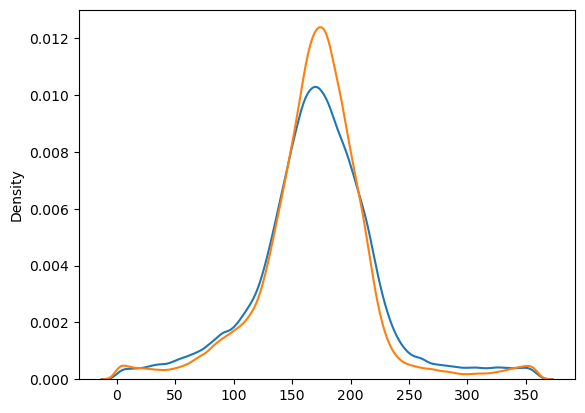

In [109]:
sns.kdeplot(df['Wind Direction (TAO)'])
sns.kdeplot(df['Wind Direction (QuikSCAT)'])

In [110]:
df

<xarray.Dataset>
Dimensions:                                            (count: 266786)
Coordinates:
  * count                                              (count) int64 0 ... 29...
Data variables: (12/88)
    Wind Direction (TAO)                               (count) float32 140.6 ...
    WDIR_QC                                            (count) float32 2.0 .....
    WDIR_DM                                            (count) |S1 b'D' ... b'D'
    Wind Speed (TAO)                                   (count) float32 6.79 ....
    WSPD_QC                                            (count) float32 2.0 .....
    WSPD_DM                                            (count) |S1 b'D' ... b'D'
    ...                                                 ...
    Meridional Wind Speed (QuikSCAT)                   (count) float64 4.602 ...
    Direction Difference (QuikSCAT - TAO)              (count) float64 0.1288...
    cos(Direction Difference (QuikSCAT - TAO))         (count) float64 1.0 .....
    sin(Direction Difference (QuikSCAT - TAO))         (count) float64 0.0022...
    Zonal Wind Speed Difference (QuikSCAT - TAO)       (count) float64 0.1173...
    Meridional Wind Speed Difference (QuikSCAT - TAO)  (count) float64 -0.117...

In [111]:
df.to_netcdf('rainFlagRemovedBuoyDataBadQualityRemovedMatchupAmbuguitiesAdded.nc')